In [ ]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)# definindo workdir

workdir = '/content/drive/MyDrive/ep_data'

Mounted at /content/drive/


In [ ]:
workdir = '/content/drive/MyDrive/ep_data'

In [ ]:
from joblib import load
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops, regionprops_table
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import classification_report, mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [ ]:
meta_set = pd.read_csv(f'{workdir}/classification_dataset.csv')
images = load(f'{workdir}/images.pkl')
labels = load(f'{workdir}/labels.pkl')

In [ ]:
# extract features from an image
dataset = pd.DataFrame()

for idx, img in enumerate(labels):
    rowset = {'idx': idx, 'class': meta_set['Objeto'].iloc[idx]}
    res = regionprops_table(
        label(img),
        intensity_image=images[idx],
        properties=(
            'area',
            'extent',
            'perimeter',
            'solidity',
            'centroid',
            'orientation',
            #'intensity_max',
            #'intensity_min',
            #'intensity_mean',
            'eccentricity',
            'inertia_tensor',
            'inertia_tensor_eigvals',
            'moments_normalized',
            #'moments_weighted_normalized',
            'inertia_tensor_eigvals',
            'eccentricity',
            #'centroid_weighted',
            #'centroid_weighted_local',
            #'equivalent_diameter_area',
            'euler_number',
            'feret_diameter_max',
            'perimeter_crofton',
            #'axis_minor_length',
            #'axis_major_length'
        )
    )
    rowset.update(res)
    dataset = pd.concat([dataset, pd.DataFrame(rowset)])

# this is the dataset with features
dataset.set_index('idx', drop=True, inplace=True)

In [ ]:
lenc = LabelEncoder()
features = [x for x in dataset.columns if x != 'class']

In [ ]:
X = dataset[features]
y = lenc.fit_transform(dataset['class'])
#Normalize all columns to the interval [0,1]
#X = (X-X.min())/(X.max()-X.min())
#Remove features with NaN values
X = X.dropna(axis=1, how='all')

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
X = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
X["class"] = dataset["class"]

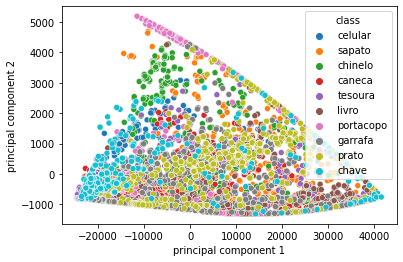

In [ ]:
import seaborn as sns
sns.scatterplot(x = X["principal component 1"], y = X["principal component 2"], hue = X["class"], )

In [ ]:
X

,principal component 1,principal component 2
0,-0.407818,-0.396437
1,-1.155876,-0.051582
2,-1.155876,-0.051582
3,-1.155877,-0.051568
4,-1.155876,-0.051582
...,...,...
7150,-1.039575,-0.199686
7151,-1.030711,-0.194440
7152,-1.044033,-0.202572
7153,-1.044033,-0.202559


In [2]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
train_size = .7, test_size = .3, stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)



#Sanity check
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

NameError: ignored

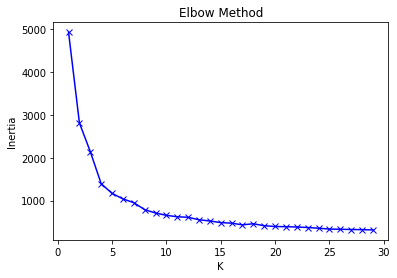

In [ ]:
#Find optimal tradeoff between K and inertia
Sum_of_squared_distances = []
K = range(1,30)
for num_clusters in K :
    kmeans = MiniBatchKMeans(n_clusters = num_clusters)
    kmeans.fit(X_train)
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('K') 
plt.ylabel('Inertia') 
plt.title('Elbow Method')
plt.show()

In [ ]:
#Try with one cluster per class first
classes = len(pd.unique(y))
kmeans = MiniBatchKMeans(n_clusters = classes)
kmeans.fit_predict(X_train)
kmeans.labels_

array([4, 2, 4, ..., 5, 2, 6], dtype=int32)

In [ ]:
def define_clusters(cluster_labels,y_train):
    cluster_class = {}
    for i in range(len(np.unique(kmeans.labels_))):
        index = np.where(cluster_labels == i,1,0)
        #find the most prevalent class for the i'th cluster 
        n = np.bincount(y_train[index==1]).argmax()
        cluster_class[i] = n
    return cluster_class

In [ ]:
cluster_class = define_clusters(kmeans.labels_,y_train)
print(cluster_class)
number_labels = np.random.rand(len(kmeans.labels_))
for i in range(len(kmeans.labels_)):
    number_labels[i] = cluster_class[kmeans.labels_[i]]

{0: 2, 1: 7, 2: 8, 3: 2, 4: 5, 5: 4, 6: 6, 7: 6, 8: 7, 9: 9}


The problem with number of clusters being equal to classes is that you need a perfect mapping to not miss out on a class. That is that one class might be assigned to 2 or more clusters, and others to 0.

In [ ]:
print(number_labels[:20].astype('int'))
print(y_train[:20])

[5 8 5 7 8 2 2 4 6 5 7 2 7 9 2 6 7 5 7 9]
[4 0 8 7 4 0 9 3 7 5 3 2 5 1 2 4 3 8 7 9]


In [ ]:
print(accuracy_score(number_labels,y_train))

0.30950479233226835


In [ ]:
def calculate_metrics(model,output):
    print('Number of clusters is {}'.format(model.n_clusters))
    print('Inertia : {}'.format(model.inertia_))
    print('Homogeneity : {}'.format(metrics.homogeneity_score(output,model.labels_)))

In [ ]:
from sklearn import metrics
K = range(10, 51, 10)

for i in K:
    kmeans = MiniBatchKMeans(n_clusters = i)
    kmeans.fit(X_train)
    calculate_metrics(kmeans,y_train)
    cluster_class = define_clusters(kmeans.labels_,y_train)
    number_labels = np.random.rand(len(kmeans.labels_))
    for i in range(len(kmeans.labels_)):
        number_labels[i] = cluster_class[kmeans.labels_[i]]
    print('Accuracy score : {}'.format(accuracy_score(number_labels,y_train)))
    print('\n')

Number of clusters is 10
Inertia : 722.439678429799
Homogeneity : 0.19160317815031824
Accuracy score : 0.31629392971246006


Number of clusters is 20
Inertia : 392.6926566913249
Homogeneity : 0.2674682924427156
Accuracy score : 0.4005591054313099


Number of clusters is 30
Inertia : 308.4383970472203
Homogeneity : 0.293807928581723
Accuracy score : 0.41293929712460065


Number of clusters is 40
Inertia : 247.58586899051522
Homogeneity : 0.33147519211116405
Accuracy score : 0.44289137380191695


Number of clusters is 50
Inertia : 198.4189672797989
Homogeneity : 0.35944860772868287
Accuracy score : 0.46865015974440893




In [ ]:
#20 clusters seems like a good tradeoff
kmeans = MiniBatchKMeans(n_clusters = 20)
kmeans.fit(X_test)
calculate_metrics(kmeans,y_test)
cluster_class = define_clusters(kmeans.labels_,y_test)
number_labels = np.random.rand(len(kmeans.labels_))
for i in range(len(kmeans.labels_)):
    number_labels[i] = cluster_class[kmeans.labels_[i]]

print('Accuracy score : {}'.format(accuracy_score(number_labels,y_test)))
print('\n')

Number of clusters is 20
Inertia : 171.3879183592071
Homogeneity : 0.2761502791374146
Accuracy score : 0.3907778295295761




In [ ]:
def estimate_error( pred, y_test):
    print("Accuracy score", accuracy_score(y_test, pred))
    print("Mean absolute error", mean_absolute_error(y_test, pred))

predictions = number_labels
for className in pd.unique(y):
    mask = [y_test == className]
    pred = predictions[tuple(mask)]
    class_y_test = y_test[tuple(mask)]
    print(lenc.inverse_transform([className]))
    estimate_error(pred, class_y_test)
    
y_pred = number_labels
target_names = lenc.inverse_transform(pd.unique(y))

print('\n')
print(classification_report(y_test, y_pred, target_names=target_names))

['celular']
Accuracy score 0.0
Mean absolute error 4.231527093596059
['sapato']
Accuracy score 0.1712962962962963
Mean absolute error 2.810185185185185
['chinelo']
Accuracy score 0.19444444444444445
Mean absolute error 2.2962962962962963
['caneca']
Accuracy score 0.20833333333333334
Mean absolute error 4.231481481481482
['tesoura']
Accuracy score 0.4027777777777778
Mean absolute error 2.810185185185185
['livro']
Accuracy score 0.4351851851851852
Mean absolute error 1.3935185185185186
['portacopo']
Accuracy score 0.9074074074074074
Mean absolute error 0.3101851851851852
['garrafa']
Accuracy score 0.35648148148148145
Mean absolute error 1.8287037037037037
['prato']
Accuracy score 0.5509259259259259
Mean absolute error 1.1018518518518519
['chave']
Accuracy score 0.6574074074074074
Mean absolute error 1.6759259259259258


              precision    recall  f1-score   support

     celular       0.30      0.21      0.25       216
      sapato       0.00      0.00      0.00       203
     ch

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


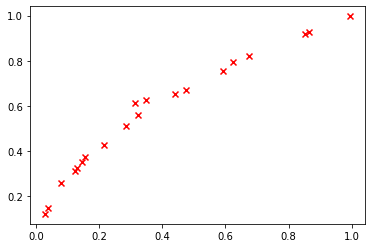

In [ ]:
#centroids = kmeans.cluster_centers_
#plt.scatter(centroids[:,0], centroids[:,1], marker="x", color='r')
